In [ ]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz


# install findspark using pip
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
import pandas as pd
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

In [ ]:
file_path = 'data_officer-less.csv'
df = pd.read_csv(file_path)
df = pd.DataFrame(df)
df = df.loc[df['allegation_count'].notna(), :]

df_spark=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",",")\
 .csv("data_officer-less.csv")


In [ ]:
y = df.loc[:,'allegation_count']
g = df.drop(columns=['gender', 'race', 'rank', 'resignation_date', 'appointed_date','allegation_count']).astype('float')

In [ ]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
g1 = imp_mean.fit_transform(g)
#g = imp_mean.transform(g)
g1 = pd.DataFrame(g1, columns=g.columns)

In [ ]:
#df = df.loc[df['allegation_count'].notna(), :]
df_spark = df_spark.where(col("allegation_count").isNotNull())
df_spark = df_spark.select("gender", "race", "rank")
df_spark = df_spark.na.fill('Unknown')

In [ ]:
'''gender_mapping = {'M': 1, 'F' : 2}
race_mappping = {'White': 1, 'Black': 2, 'Hispanic': 3}
df['rank'] = df['rank'].astype('category')
label1 = dict(enumerate(df['rank'].cat.categories))
x[['rank']] = x[['rank']].apply(lambda a: a.cat.codes)'''

In [ ]:
label_indexer_gender = StringIndexer()\
         .setInputCol ("gender")\
         .setOutputCol ("gender_label")
label_indexer_model_gender=label_indexer_gender.fit(df_spark)
df_spark=label_indexer_model_gender.transform(df_spark)

label_indexer_race = StringIndexer()\
         .setInputCol ("race")\
         .setOutputCol ("race_label")
label_indexer_model_race=label_indexer_race.fit(df_spark)
df_spark=label_indexer_model_race.transform(df_spark)

label_indexer_rank = StringIndexer()\
         .setInputCol ("rank")\
         .setOutputCol ("rank_label")
label_indexer_model_rank=label_indexer_rank.fit(df_spark)
df_spark=label_indexer_model_rank.transform(df_spark)


In [ ]:
df_spark.show(13)

In [ ]:
g2 = df_spark.select("gender_label", 'race_label', 'rank_label')
g2 = g2.toPandas()

In [ ]:
x = g1.join(g2)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
# Special note: for a 60/20/20 split (if you want a validation step), just do the above step again on the train set with a 2/3, 1/3 split
X_train.shape

(27071, 20)

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
predictions1 = model.predict(X_train)

params = np.append(model.intercept_,model.coef_)
newX = np.append(np.ones((len(X_train),1)), X_train, axis=1)
MSE = (sum((y_train-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

from scipy import stats
p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

regression_results = pd.DataFrame()
regression_results["Coefficients"],regression_results["Standard Errors"],regression_results["t values"],regression_results["p values"] = [params,sd_b,ts_b,p_values]
print(regression_results)

    Coefficients  Standard Errors  t values  p values
0        -9.4546            3.103    -3.047     0.002
1         0.0029            0.002     1.847     0.065
2         0.0171            0.001    16.699     0.000
3         0.0428            0.001    41.022     0.000
4         0.0157            0.001    17.595     0.000
5         0.0069            0.001    11.053     0.000
6        -0.0159            0.001   -17.673     0.000
7         1.0689            0.046    23.391     0.000
8         0.0479            0.007     7.055     0.000
9        -0.0000            0.000    -2.905     0.004
10        0.0000            0.000    15.101     0.000
11       -0.0140            0.050    -0.283     0.777
12        0.0355            0.001    31.734     0.000
13        0.0027            0.000    10.400     0.000
14        0.1560            0.049     3.200     0.001
15        0.2277            0.005    42.435     0.000
16        1.3498            0.004   371.897     0.000
17       -0.0255            

In [ ]:
g = (p_values[1:] < 0.0001)
X_train_new = X_train.iloc[:,g]
X_train_new.shape

(27071, 14)

In [ ]:
model2 = LinearRegression()
model2.fit(X_train_new, y_train)

predictions2 = model2.predict(X_train_new)

params = np.append(model2.intercept_,model2.coef_)
newX = np.append(np.ones((len(X_train_new),1)), X_train_new, axis=1)
MSE = (sum((y_train-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

regression_results = pd.DataFrame()
regression_results["Coefficients"],regression_results["Standard Errors"],regression_results["t values"],regression_results["p values"] = [params,sd_b,ts_b,p_values]
print(regression_results)

    Coefficients  Standard Errors  t values  p values
0        -3.9265            0.131   -30.006       0.0
1         0.0174            0.001    17.155       0.0
2         0.0425            0.001    41.167       0.0
3         0.0167            0.001    25.727       0.0
4         0.0069            0.001    11.082       0.0
5        -0.0160            0.001   -17.862       0.0
6         1.0571            0.014    75.303       0.0
7         0.0489            0.007     7.208       0.0
8         0.0000            0.000    16.259       0.0
9         0.0358            0.001    32.477       0.0
10        0.0026            0.000    10.168       0.0
11        0.2297            0.005    42.990       0.0
12        1.3504            0.004   373.100       0.0
13        0.2785            0.046     6.114       0.0
14       -0.1141            0.021    -5.564       0.0


In [ ]:
y_pred1 = model.predict(X_test)
y_pred2 = model2.predict(X_test.iloc[:,g])

[Text(0, 0.5, 'actual'),
 Text(0.5, 0, 'predicted'),
 Text(0.5, 1.0, 'selected test dataset')]

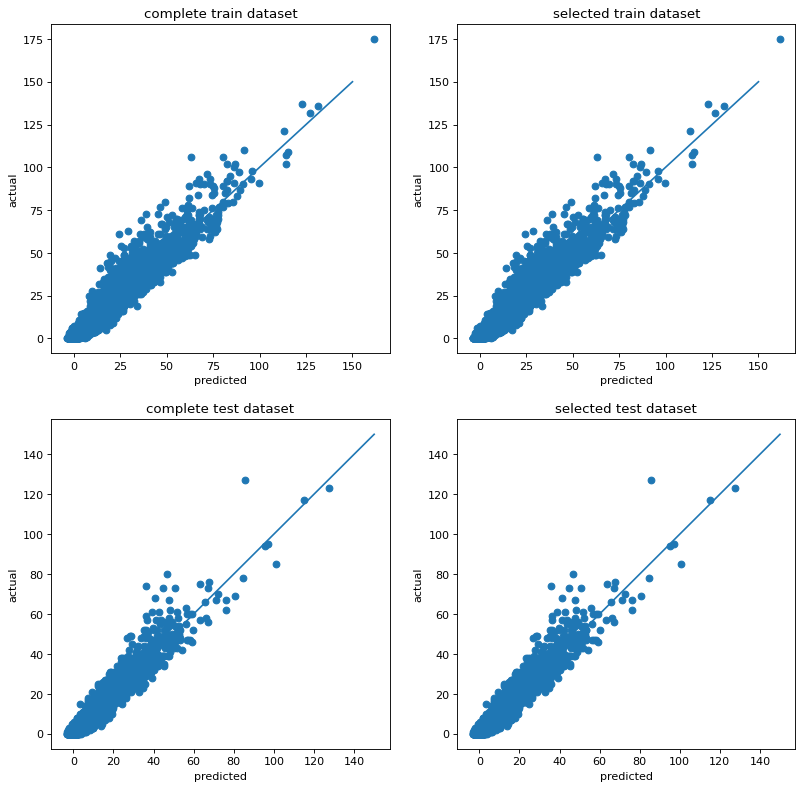

In [ ]:
# show a visualization for a scatter plot
fig = plt.figure(figsize=(12,12), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(221)
ax1.scatter(predictions1, y_train)
ax2 = fig.add_subplot(222)
ax2.scatter(predictions2, y_train)
ax3 = fig.add_subplot(223)
ax3.scatter(y_pred1, y_test)
ax4 = fig.add_subplot(224)
ax4.scatter(y_pred2, y_test)
ax1.plot([0,150],[0,150])
ax2.plot([0,150],[0,150])
ax3.plot([0,150],[0,150])
ax4.plot([0,150],[0,150])
ax1.set(title = 'complete train dataset', ylabel='actual', xlabel='predicted')
ax2.set(title = 'selected train dataset', ylabel='actual', xlabel='predicted')
ax3.set(title = 'complete test dataset', ylabel='actual', xlabel='predicted')
ax4.set(title = 'selected test dataset', ylabel='actual', xlabel='predicted')

In [ ]:
# compute accuracy score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print('Original Training Data')
print('R^2 Score:', r2_score(predictions1, y_train))
print('MSE:', mean_squared_error(predictions1, y_train))
print('RMSE:', np.sqrt(mean_squared_error(predictions1, y_train)))
print('\n')

print('Original Test Data')
print('R^2 Score:', r2_score(y_test, y_pred1))
print('MSE:', mean_squared_error(y_test, y_pred1))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred1)))
print('\n')

print('Selected Training Data')
print('R^2 Score:', r2_score(predictions2, y_train))
print('MSE:', mean_squared_error(predictions2, y_train))
print('RMSE:', np.sqrt(mean_squared_error(predictions2, y_train)))
print('\n')

print('Selected Test Data')
print('R^2 Score:', r2_score(y_test, y_pred2))
print('MSE:', mean_squared_error(y_test, y_pred2))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred2)))

Original Training Data
R^2 Score: 0.9341134525430177
MSE: 7.43119786758533
RMSE: 2.7260223527303165


Original Test Data
R^2 Score: 0.934295877005224
MSE: 7.821275931705167
RMSE: 2.7966544176399712


Selected Training Data
R^2 Score: 0.9340408260920464
MSE: 7.438882380152808
RMSE: 2.7274314620449784


Selected Test Data
R^2 Score: 0.934151113643659
MSE: 7.8385082474867955
RMSE: 2.7997336029498943


In [ ]:
X_train_new.columns

Index(['complaint_percentile', 'civilian_allegation_percentile',
       'honorable_mention_percentile', 'internal_allegation_percentile',
       'trr_percentile', 'sustained_count', 'civilian_compliment_count',
       'current_salary', 'honorable_mention_count', 'last_unit_id',
       'trr_count', 'unsustained_count', 'gender_label', 'race_label'],
      dtype='object')